# According to wiki "sumary of lstm_speech_siamese", we can say the one shot may not be the best net structure for the problem. 

Here I try to build another net structure. 

input:
choose an anchor word, and random other words. combine all mfcc into input. the length of inputs may change. 
Output:
the one hot vector, the length will be length(input) - 1. [0, 0, 0, 1, .....]. the 1 means that words is the best match for anchor. 
the output can be fixed to 128. that means the input cannot beyond 128. in another word, the max commands is not beyond 128. 

the network

### mfcc->TimeDistributed(Dense)->gru--|
### mfcc->TimeDistributed(Dense)->gru--|
### ....................      --|-lstm(dynamic input->1024 vector)->dense(1024)->dense(256)->dense(128, sigmoid)->output
### mfcc->TimeDistributed(Dense)->gru--|
### mfcc->TimeDistributed(Dense)->gru--|

the point is how to build a dynamic lstm input. 

Keep mfcc pre-process


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import hashlib
import math, time, datetime
import os.path
import random
import re
import sys
import tarfile
import shutil
#print(sys.executable)
import matplotlib.pyplot as plt
import pydot
import graphviz
import numpy as np
import librosa as rosa
import librosa.display
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import numpy as np
from sklearn import preprocessing #copy from echo 1110/2018

import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Lambda, BatchNormalization, Activation, LSTM, GRU, concatenate, TimeDistributed
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from scipy.spatial import distance
from tensorflow.keras.utils import multi_gpu_model
#from tensorflow.python import debug as tf_debug
#from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
#from tensorflow.python.ops import io_ops
#from tensorflow.python.platform import gfile
#from tensorflow.python.util import compat
import local_config
default_improving_torlerence = 32 # for how many time no acc improving then terminate the training.
default_number_of_mfcc=128
default_sample_rate=16000
default_hop_length=512 
default_wav_duration=1 # 1 second
default_train_samples=10000
default_test_samples=100
default_epochs=10
default_batch_size=1024
default_sequence_size=5 # the default sequence size for how many wavs compare to anchor. 
default_train_wanted_words=["one", "two",  "backward", "bird", "cat", "dog", "five", "forward", "four", "go", "happy", "house", "learn", "left", "marvin", "nine", "no", "off", "right", "seven", "sheila", "stop", "three", "tree",  "wow", "zero","up"]
default_test_wanted_words=["bed", "eight", "visual", "follow"]



default_kernel_regularizer=regularizers.l2(0.01)
default_activity_regularizer=None #regularizers.l1(0.01)

#sess = K.get_session()
#sess = tf_debug.LocalCLIDebugWrapperSession(sess)
#K.set_session(sess)

#set backgroud noise as the base mfcc input
default_noise_background_wav=local_config.speech_data_dir+"/_background_noise_/dude_miaowing.wav"
base_loader, base_sample_rate = rosa.load(default_noise_background_wav, sr=default_sample_rate, duration=1.0)
base_mfcc = rosa.feature.mfcc(y=base_loader, sr=base_sample_rate, n_mfcc=default_number_of_mfcc)
#print(base_mfcc.shape)

### One shot keyword trigger


Here is another implementation of one-shot learning of keyword trigger with librosa mfcc. 
librosa cannot put into tensorflow graph. so mfcc computation will be done before conv network. 
that means load_wav_mfcc has to convert all wav file to mfcc vector. 
Here i have to understand
    1, what is the good mfcc vector dimension. 20, 127 may not be the right input for conv network. 
    2, even the mfcc output of librosa is not the same as tensorflow contrib.decode wav, it is enough if it has all audio feature. put librosa mfcc output as input of conv net, it will do good learning about feature abstraction. 
    3, conv net may not be that difficult. just like conv2d -> maxpooling -> conv2d->flatten->dense with softmax. 
    4, build the train network with librosa and conv net.
    5, take the dense vector output as feature extractor. 
    6, build siamese network with the feature extractor. 
    7, may add couples of dense layer to learn the feature mapping and comparation of siamese. 
    8, if that works, we get an one-shot learning for key word trigger...
    9, in reality, we still have to work out how to split the audio stream into audio clip as the input the librosa mfcc.
    

### MFCC 

extract MFCC from wav file
what is the wav parameter for MFCC output

tensorflow speech command parameter 
{'desired_samples': 16000, 'window_size_samples': 480, 'window_stride_samples': 160, 'spectrogram_length': 98, 'fingerprint_width': 40, 'fingerprint_size': 3920, 'label_count': 12, 'sample_rate': 16000, 'preprocess': 'mfcc', 'average_window_width': -1}

Mel-frequency cepstral coefficients (MFCCs)
Parameters:	
y:np.ndarray [shape=(n,)] or None
audio time series
sr:number > 0 [scalar]
sampling rate of y
S:np.ndarray [shape=(d, t)] or None
log-power Mel spectrogram
n_mfcc: int > 0 [scalar]
number of MFCCs to return
Returns:	
M:np.ndarray [shape=(n_mfcc, t)]
MFCC sequence

need more study about MFCC output


## How to calculate the lenght of mfcc vector
Short Answer

You can specify the change the length by changing the parameters used in the stft calculations. The following code will double the size of your output (20 x 113658)

data = librosa.feature.mfcc(y=y, sr=sr, n_fft=1012, hop_length=256, n_mfcc=20)
Long Answer

Librosa's librosa.feature.mfcc() function really just acts as a wrapper to librosa's librosa.feature.melspectrogram() function (which is a wrapper to librosa.core.stft and librosa.filters.mel functions).

All of the parameters pertaining to segementation of the audio signal - namely the frame and overlap values - are specified utilized in the Mel-scaled power spectrogram function (with other tune-able parameters specified for nested core functions). You specify these parameters as keyword arguments in the librosa.feature.mfcc() function.

All extra **kwargs parameters are fed to librosa.feature.melspectrogram() and subsequently to librosa.filters.mel()

By Default, the Mel-scaled power spectrogram window and hop length are the following:

n_fft=2048

hop_length=512

So assuming you used the default sample rate (sr=22050), the output of your mfcc function makes sense:

output length = (seconds) * (sample rate) / (hop_length)

(1319) * (22050) / (512) = 56804 samples


the mfcc vector size is 128 * 32   

1 * 16000/512 = 31.25 = 32 

(32, 128)


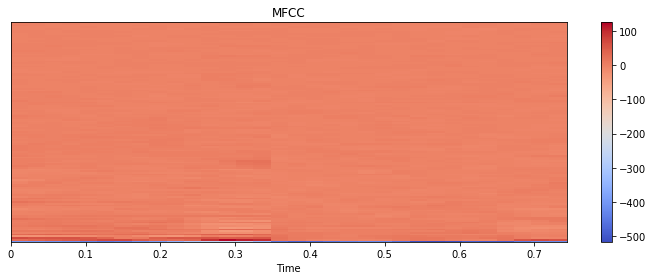

In [4]:

def get_default_mfcc_length(default_wav_duration=1):
    length = int(math.ceil(default_wav_duration * default_sample_rate / default_hop_length))
    return length

def load_wav_mfcc(filename):
    default_mfcc_length = get_default_mfcc_length()
    #the base_mfcc is the (128, 32) vector
    assert(base_mfcc.shape[1] == 32)
    
    out_mfcc = np.copy(base_mfcc)
    wav_loader, sample_rate = rosa.load(filename, sr=default_sample_rate)
    #print(rosa.get_duration(wav_loader, sample_rate))
    wav_mfcc = rosa.feature.mfcc(y=wav_loader, sr=default_sample_rate, n_mfcc=default_number_of_mfcc)
    out_mfcc[:, 0:wav_mfcc.shape[1]] = wav_mfcc    
    out_mfcc = np.transpose(out_mfcc)
    return out_mfcc

def mfcc_display(mfccs):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    
wav_mfcc_data = load_wav_mfcc(local_config.speech_data_dir + "/six/f6a380e7_nohash_0.wav")
print(wav_mfcc_data.shape)
mfcc_display(np.transpose(wav_mfcc_data))



# Wav MFCC loader
Wav file loader and export mfcc sequence. 

0, go throught all wav file to add background voice into command wav file
1, go through all wav file and convert to MFCC sequence
2, construct pair of MFCC sequence and a target (0 or 1, 0 for different command, 1 for the same command)
    the same word * 1000, random generate key index, the first index of wav, and the second index of wav. 
    the diff word * 1000, random generae two key index, the first index of wav, and the second index of wav. 
    the format will be [mfcc 1, mfcc 2, 0/1 for the same or different]
3, prepare pair of MFCC and targets according to batch size.  

the 0 seq vec
0.0
0.0
0.0
1.0
0.0
the 1 seq vec
0.0
0.0
0.0
1.0
0.0
the 2 seq vec
1.0
0.0
0.0
0.0
0.0


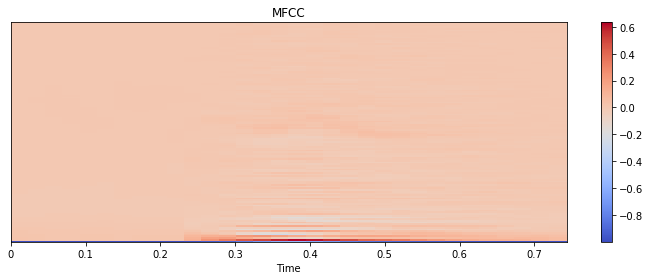

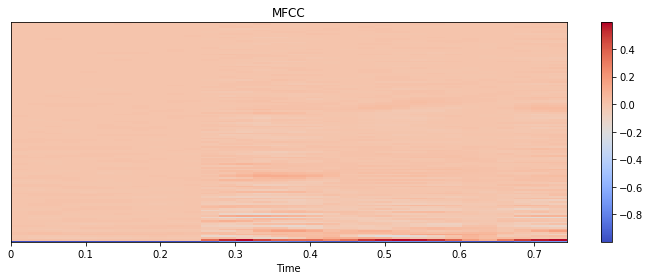

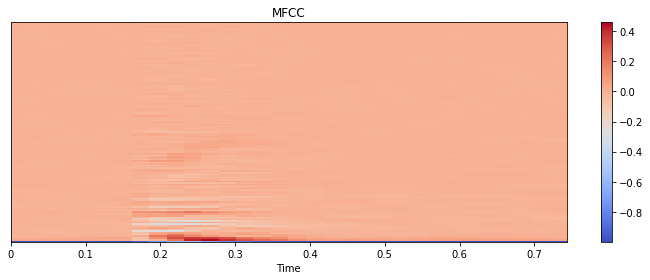

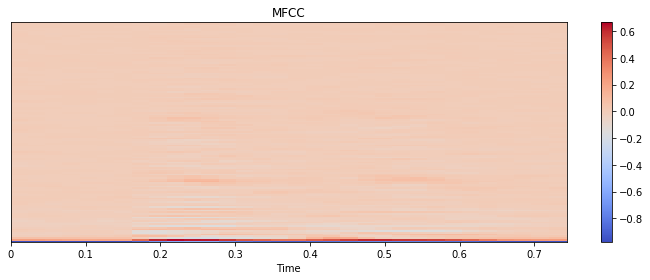

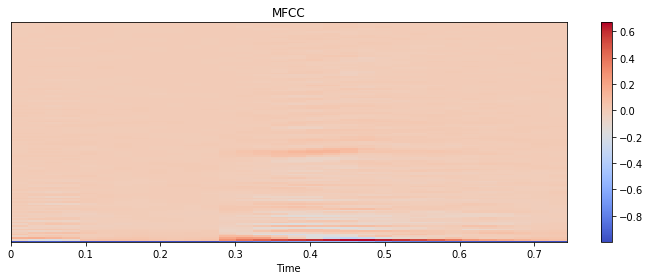

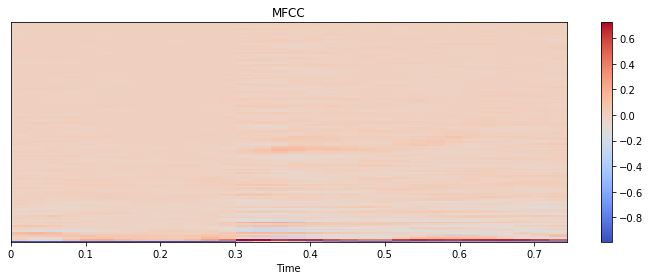

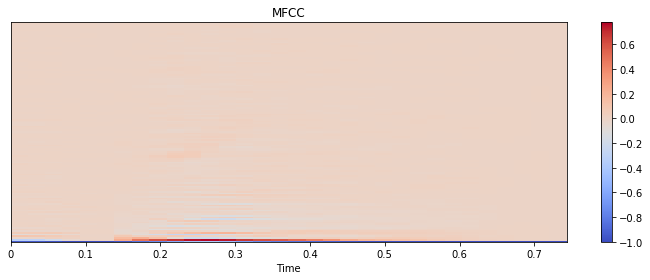

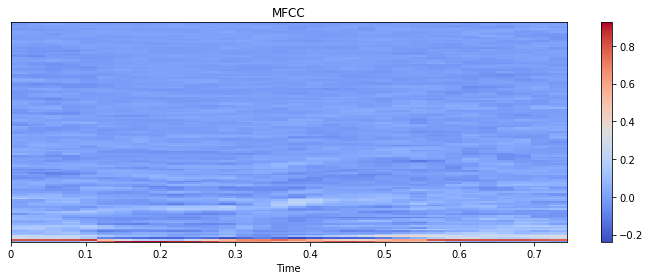

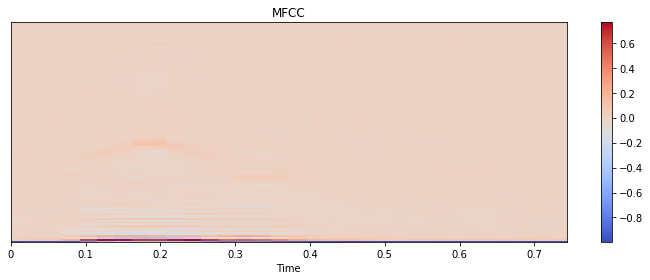

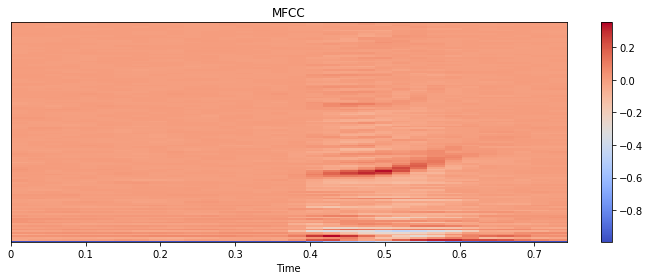

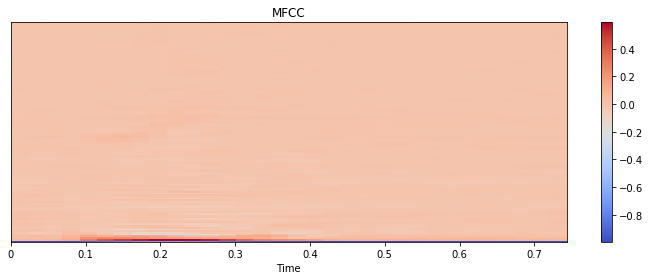

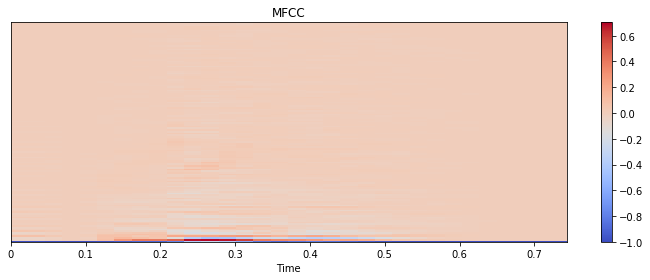

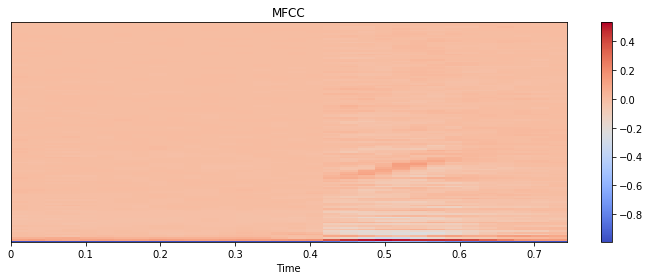

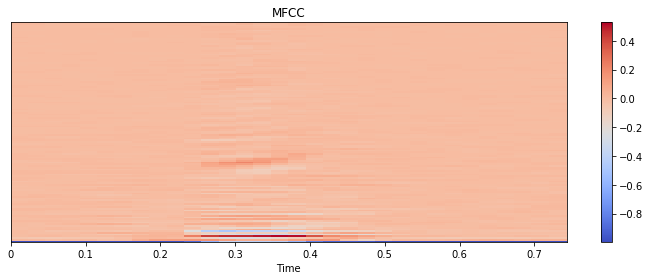

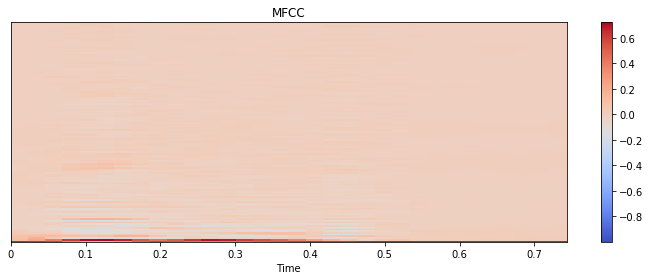

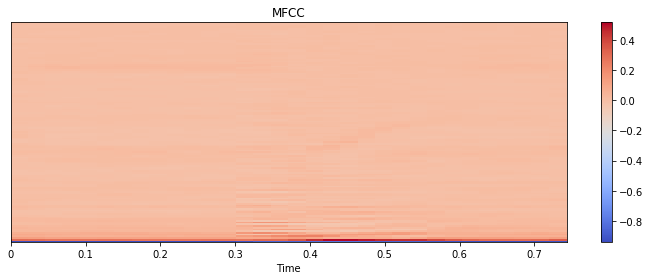

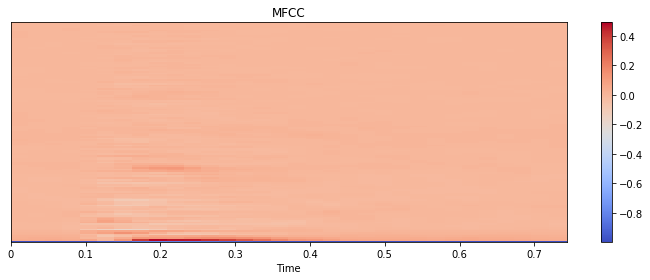

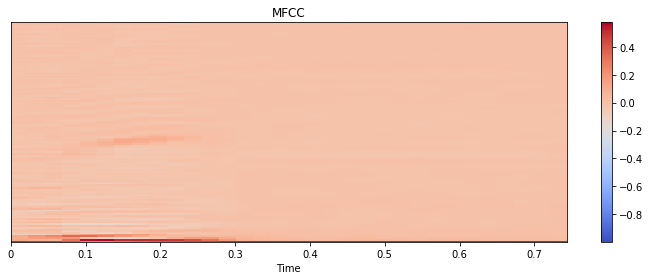

In [5]:
class WavMFCCLoader(object):
    def __init__(self, data_dir, wanted, validation_percentage=0, testing_percentage=0):
        self.data_dir = data_dir
        self.wanted = wanted
        self.default_mfcc_length=get_default_mfcc_length(default_wav_duration)
        self.wav_files = dict()
        self.wav_file_index()
        self.mfccs_mean = 0
        self.mfccs_std = 0
        
        
    def wav_file_index(self):
        for dirpath, dirnames, files in os.walk(self.data_dir):
            for name in files:
                if name.lower().endswith('.wav'):
                    word_name = dirpath.rsplit(local_config.default_split, 1)[1];
                    if word_name in self.wanted:
                        file_name = os.path.join(dirpath, name)
                        #print(file_name, dirpath, word_name)
    
                        if word_name in self.wav_files.keys():
                            self.wav_files[word_name].append(file_name)
                        else:
                            self.wav_files[word_name] = [file_name]
                    
        return self.wav_files
    def mfcc_preprocess(self, mfcc_data_in, preprocess="l2-normalize"):
        mfcc_data_out = np.zeros(mfcc_data_in.shape)
        if preprocess == "global":
            self.get_sample_mean_std()
            mfcc_data_out = (mfcc_data_in - self.mfccs_mean[0:mfcc_data_in.shape[0], :]) / self.mfccs_std[0:mfcc_data_in.shape[0], :]
        elif preprocess == "z-score":
            mfcc_data_out = preprocessing.scale(mfcc_data_in)
        elif preprocess == "max-min-scaler":
            mfcc_data_out = preprocessing.MinMaxScaler().fit_transform(mfcc_data_in)
        elif preprocess == "l2-normalize":
            mfcc_data_out = preprocessing.normalize(mfcc_data_in, norm='l2')
        else:
            raise ValueError("unknown proprocess")  
        return mfcc_data_out
    #sequence size here means how many wavs compare to the anchor. 
    #the output will be anchor mfcc, the sequence mfcc and one-hot vector 
    #to indicate which one in the sequence is the same word as the anchor
    def wavs_to_mfcc_sequence(self, local_preprocess="l2-normalize", sequence_size=5):
        how_many_words = len(self.wanted)
        a_wav_index = b_wav_index = -1
        #anchor mfcc
        a_index = random.randint(0, how_many_words - 1) #anchor index
        a_wav_index = random.randint(0, len(self.wav_files[self.wanted[a_index]]) - 1)
        mfcc_anchor = load_wav_mfcc(self.wav_files[self.wanted[a_index]][a_wav_index])
        mfcc_anchor = self.mfcc_preprocess(mfcc_anchor, preprocess=local_preprocess)
        #sequence of mfccs
        sequence_vec = np.zeros((sequence_size))
        mfcc_seqs = np.zeros((sequence_size, mfcc_anchor.shape[0], mfcc_anchor.shape[1]))
        #where to put the same word wav as anchor
        set_one_pos = random.randint(0, sequence_size - 1) 
        for i in range(sequence_size):
            if (i == set_one_pos):
                b_wav_index = random.randint(0, len(self.wav_files[self.wanted[a_index]]) - 1)
                mfcc_seq = load_wav_mfcc(self.wav_files[self.wanted[a_index]][b_wav_index])    
                sequence_vec[i] = 1
            else:
                b_index = random.randint(0, how_many_words - 1)
                while (a_index == b_index): # there has to be only one wav file with the same word as anchor
                    b_index = random.randint(0, how_many_words - 1)
                b_wav_index = random.randint(0, len(self.wav_files[self.wanted[b_index]]) - 1)
                mfcc_seq = load_wav_mfcc(self.wav_files[self.wanted[b_index]][b_wav_index])
                sequence_vec[i] = 0
                
            mfcc_seqs[i] = self.mfcc_preprocess(mfcc_seq, preprocess=local_preprocess)
        #mfcc_seqs = np.transpose(mfcc_seqs, (1, 2, 0))            
        #print("aaa", mfcc_1.shape, mfcc_2.shape)    
        return mfcc_anchor, mfcc_seqs, sequence_vec
        
    def get_mfcc_sequences(self, how_many, local_sequence_size = 5, preprocess='l2-normalize'):
        mfcc_anchors = np.zeros((how_many, self.default_mfcc_length, default_number_of_mfcc))
        mfcc_sequences = np.zeros((how_many, sequence_size, self.default_mfcc_length, default_number_of_mfcc))
        sequence_vecs = np.zeros((how_many, sequence_size))
        for i in range(how_many):
            
            mfcc_anchors[i], mfcc_sequences[i], sequence_vecs[i] = self.wavs_to_mfcc_sequence(sequence_size = local_sequence_size, local_preprocess = preprocess)
            
            
    
        return mfcc_anchors, mfcc_sequences, sequence_vecs
    
    def get_mfcc_for_word(self, wanted, local_preprocess='l2-normalize'):
        mfcc_data = np.zeros((self.default_mfcc_length, default_number_of_mfcc))
        if (wanted in self.wanted):
            wav_index = random.randint(0, len(self.wav_files[wanted]) - 1)
            mfcc_data_tmp = load_wav_mfcc(self.wav_files[wanted][wav_index])
            mfcc_data_tmp = self.mfcc_preprocess(mfcc_data_tmp, preprocess=local_preprocess)
            
        
            mfcc_data[0:mfcc_data_tmp.shape[0], : ] = mfcc_data_tmp
        else:
            raise ValueError("the word is not in the list")
            
        return mfcc_data, self.wav_files[wanted][wav_index]
        
    def get_sample_mean_std(self):
        count = 0
        for i in (self.wanted):
            #print(i)
            for j in range(len(self.wav_files[i])):
                #print(self.wav_files[i][j])
                count += 1
        #print("count:", count)
        mfccs = np.zeros((count, self.default_mfcc_length, default_number_of_mfcc))
        index = 0
        for i in (self.wanted):
            for j in range(len(self.wav_files[i])):       
                mfcc_ = load_wav_mfcc(self.wav_files[i][j])
                mfccs[index, 0:mfcc_.shape[0], : ] = mfcc_
                index += 1
        self.mfccs_mean = mfccs.mean(0)
        self.mfccs_std = mfccs.std(0)
        

#loader = WavMFCCLoader(local_config.speech_data_dir, wanted=["one", "two", "bed", "backward", "bird", "cat", "dog", "eight", "five", "follow", "forward", "four", "go", "happy", "house", "learn", "left", "marvin", "nine", "no", "off", "right", "seven", "sheila", "stop", "three", "tree", "visual", "wow", "zero"])
loader = WavMFCCLoader(local_config.speech_data_dir, wanted=["one", "two", "bed", "backward"])
sequence_size = 5
#wav_list = loader.wav_file_index()
mfcc_anchors, mfcc_sequences, sequence_vecs = loader.get_mfcc_sequences(3, local_sequence_size=sequence_size, preprocess='l2-normalize')
for i in range(3):
    mfcc_display(np.transpose(mfcc_anchors[i]))
    print("the " + str(i) + " seq vec")
    for j in range(sequence_size):
        mfcc_display(np.transpose(mfcc_sequences[i][j]))
        print(sequence_vecs[i][j])
        

## Data loader for training and testing 

In [6]:

def read_data_file(file_name):
    f = open(file_name, "rb")
    t = np.load(f)
    #print("shape:", t.shape)
    f.close()
    return t

def write_data_file(file_name, data):
    f = open(file_name, "wb")
    np.save(f, data)
    f.close()

def save_model_file(model):
    json_model = model.to_json()    
    with open(local_config.default_processed_data_path + local_config.default_split + "model_description.txt", "w") as out_file:
        out_file.write(json_model)
        out_file.close()
    plot_model(model, to_file=local_config.default_processed_data_path + local_config.default_split + 'model_description.png')
    

def store_processed_data(local_train_samples=default_train_samples, sequence_size = default_sequence_size,local_test_samples=default_test_samples, local_process_data_path=local_config.default_processed_data_path, local_preprocess='l2-normalize', local_train_wanted=default_train_wanted_words, local_test_wanted=default_test_wanted_words):
    train_loader = WavMFCCLoader(local_config.speech_data_dir, wanted=local_train_wanted)
    mfcc_train_anchors, mfcc_train_seqs, train_seq_vecs = train_loader.get_mfcc_sequences(local_train_samples, local_sequence_size = sequence_size, preprocess=local_preprocess)
    mfcc_eval_anchors, mfcc_eval_seqs, eval_seq_vecs = train_loader.get_mfcc_sequences(local_test_samples, local_sequence_size = sequence_size, preprocess=local_preprocess)

    test_loader  = WavMFCCLoader(local_config.speech_data_dir, wanted=local_test_wanted)
    mfcc_test_anchors, mfcc_test_seqs, test_seq_vecs = test_loader.get_mfcc_sequences(local_test_samples, local_sequence_size = sequence_size, preprocess=local_preprocess)

    #store the training mfcc anchor to np file
    filename_train_mfcc_anchors = local_process_data_path + local_config.default_split + "mfcc_train_anchors_" + str(sequence_size) + '_' + str(local_train_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_train_mfcc_anchors, mfcc_train_anchors)
    
    #store the training mfcc sequences to np file
    filename_train_mfcc_sequences = local_process_data_path + local_config.default_split + "mfcc_train_sequences_" + str(sequence_size) + '_'  + str(local_train_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_train_mfcc_sequences, mfcc_train_seqs)
    
    #store the training sequence vector data to np file
    filename_train_seq_vecs = local_process_data_path + local_config.default_split + "seq_vecs_train_" + str(sequence_size) + '_'  + str(local_train_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_train_seq_vecs, train_seq_vecs)
    
    #store the eval mfcc anchor to np file
    filename_test_mfcc_anchors = local_process_data_path + local_config.default_split + "mfcc_test_anchors_" + str(sequence_size) + '_' + str(local_test_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_test_mfcc_anchors, mfcc_test_anchors)
    
    #store the eval mfcc sequences to np file
    filename_test_mfcc_sequences = local_process_data_path + local_config.default_split + "mfcc_test_sequences_" + str(sequence_size) + '_'  + str(local_test_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_test_mfcc_sequences, mfcc_test_seqs)
    
    #store the eval sequence vector data to np file
    filename_test_seq_vecs = local_process_data_path + local_config.default_split + "seq_vecs_test_" + str(sequence_size) + '_'  + str(local_test_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_test_seq_vecs, test_seq_vecs)
    
    #store the eval mfcc anchor to np file
    filename_eval_mfcc_anchors = local_process_data_path + local_config.default_split + "mfcc_eval_anchors_" + str(sequence_size) + '_' + str(local_test_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_eval_mfcc_anchors, mfcc_eval_anchors)
    
    #store the eval mfcc sequences to np file
    filename_eval_mfcc_sequences = local_process_data_path + local_config.default_split + "mfcc_eval_sequences_" + str(sequence_size) + '_'  + str(local_test_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_eval_mfcc_sequences, mfcc_eval_seqs)
    
    #store the eval sequence vector data to np file
    filename_eval_seq_vecs = local_process_data_path + local_config.default_split + "seq_vecs_eval_" + str(sequence_size) + '_'  + str(local_test_samples) + "_" + local_preprocess + ".npy"
    write_data_file(filename_eval_seq_vecs, eval_seq_vecs)
    
    
def load_processed_data(local_train_samples=default_train_samples, local_test_samples=default_test_samples, local_process_data_path=local_config.default_processed_data_path, sequence_size = default_sequence_size, local_preprocess='l2-normalize'):
    
    filename_train_mfcc_anchor = local_process_data_path + local_config.default_split + "mfcc_train_anchors_" + str(sequence_size) + '_'  + str(local_train_samples) + "_" + local_preprocess + ".npy"    
    
    if not (os.path.isfile(filename_train_mfcc_anchor)):
        store_processed_data(local_train_samples, sequence_size, local_test_samples, local_process_data_path, local_preprocess)
    
    filename_train_mfcc_anchors = local_process_data_path + local_config.default_split + "mfcc_train_anchors_" + str(sequence_size) + '_' + str(local_train_samples) + "_" + local_preprocess + ".npy"
    mfcc_train_anchors = read_data_file(filename_train_mfcc_anchors)
    filename_train_mfcc_sequences = local_process_data_path + local_config.default_split + "mfcc_train_sequences_" + str(sequence_size) + '_' + str(local_train_samples) + "_" + local_preprocess + ".npy"
    mfcc_train_sequences = read_data_file(filename_train_mfcc_sequences)
    filename_train_seq_vecs = local_process_data_path + local_config.default_split + "seq_vecs_train_" + str(sequence_size) + '_' + str(local_train_samples) + "_" + local_preprocess + ".npy"
    train_seq_vecs = read_data_file(filename_train_seq_vecs)
    filename_eval_mfcc_anchors = local_process_data_path + local_config.default_split + "mfcc_eval_anchors_" + str(sequence_size) + '_' + str(local_test_samples) + "_" + local_preprocess + ".npy"
    mfcc_eval_anchors = read_data_file(filename_eval_mfcc_anchors)
    filename_eval_mfcc_sequences = local_process_data_path + local_config.default_split + "mfcc_eval_sequences_" + str(sequence_size) + '_' + str(local_test_samples) + "_" + local_preprocess + ".npy"
    mfcc_eval_sequences = read_data_file(filename_eval_mfcc_sequences)
    filename_eval_seq_vecs = local_process_data_path + local_config.default_split + "seq_vecs_eval_" + str(sequence_size) + '_' + str(local_test_samples) + "_" + local_preprocess + ".npy"
    eval_seq_vecs = read_data_file(filename_eval_seq_vecs)
    filename_test_mfcc_anchors = local_process_data_path + local_config.default_split + "mfcc_test_anchors_" + str(sequence_size) + '_' + str(local_test_samples) + "_" + local_preprocess + ".npy"
    mfcc_test_anchors = read_data_file(filename_test_mfcc_anchors)
    filename_test_mfcc_sequences = local_process_data_path + local_config.default_split + "mfcc_test_sequences_" + str(sequence_size) + '_' + str(local_test_samples) + "_" + local_preprocess + ".npy"
    mfcc_test_sequences = read_data_file(filename_test_mfcc_sequences)
    filename_test_seq_vecs = local_process_data_path + local_config.default_split + "seq_vecs_test_" + str(sequence_size) + '_' + str(local_test_samples) + "_" + local_preprocess + ".npy"
    test_seq_vecs = read_data_file(filename_test_seq_vecs)    
    
    return mfcc_train_anchors, mfcc_train_sequences, train_seq_vecs, mfcc_eval_anchors, mfcc_eval_sequences, eval_seq_vecs, mfcc_test_anchors, mfcc_test_sequences, test_seq_vecs

#load_processed_data(local_train_samples=10000, local_test_samples=100, local_preprocess='z-score')
_=load_processed_data(local_train_samples=10000, sequence_size = 5, local_test_samples=100, local_preprocess='l2-normalize')
#load_processed_data(local_train_samples=10000, local_test_samples=100, local_preprocess='global')
#load_processed_data(local_train_samples=10000, local_test_samples=100, local_preprocess='max-min-scaler')

# LSTM Network

create a keras lstm network, take mfcc vector as input.

the speech command mfcc input shape is (?, mfcc_number, hop_number, 1)




In [7]:
def create_lstm_model(local_input_shape, is_training=True):
    model = Sequential()
    model.add(TimeDistributed(Dense(128, kernel_regularizer=default_kernel_regularizer, activity_regularizer=default_activity_regularizer, name='time_dense'), input_shape=local_input_shape))
    model.add(GRU(128, return_sequences=False, stateful=False))
    #model.add(GRU(256, return_sequences=True, stateful=False))
    #model.add(GRU(256, stateful=False))

    model.add(Dense(128, kernel_regularizer=default_kernel_regularizer, activity_regularizer=default_activity_regularizer, name='after_gru_dense'))
    model.add(BatchNormalization())
    model.add(Activation("relu")) 
    #if (is_training):
    #    model.add(Dropout(0.5))
    #model.add(Dense(labels_count, activation="softmax"))
    
    return model


def euclidean_distance(x):     
    ret = K.mean( K.square(x[0]-x[1]),axis=-1,keepdims=True)
    #print(ret.shape)
    return ret #K.mean( K.square(x1-x2),axis=-1,keepdims=True)
    #return distance.euclidean(x[0], x[1])

def cosine_distance(x):        
    x1 = K.l2_normalize(x[0], axis=-1)
    x2 = K.l2_normalize(x[1], axis=-1)
    return -K.mean(x1 * x2, axis=-1, keepdims=True)

def create_siamese_model(input_shape, sequence_size = default_sequence_size, siamese_mode = 'abs'):
    
    anchor_input = Input(input_shape, name='anchor_input')
    keras_model = create_lstm_model(input_shape)
    anchor_encoder = keras_model(anchor_input)
    seq_inputs = [anchor_input]
    seq_inputs_encoder = []
    distance_vector = []
    for i in range(sequence_size):
        seq_input = Input(input_shape, name='seq'+str(i)+'_input')
        seq_encoder = keras_model(seq_input)
        if (siamese_mode == 'dot'):
            calculate_layer = Lambda(lambda x: x[0]*x[1], name='lambda_dot'+str(i))([anchor_encoder, seq_encoder])
        elif (siamese_mode == 'abs'):
            calculate_layer = Lambda(lambda x: tf.abs(x[0]-x[1], name='lambda_abs'+str(i)))([anchor_encoder, seq_encoder])
        elif (siamese_mode == 'euclidean'):
            calculate_layer = Lambda(euclidean_distance, name='lambda_euclidean'+str(i))([anchor_encoder, seq_encoder])
        elif (siamese_mode == 'cosine'):
            calculate_layer = Lambda(cosine_distance, name='lambda_cosine'+str(i))([anchor_encoder, seq_encoder])
        else:
            raise ValueError("unknown siamese_mode")   
        seq_inputs.append(seq_input)
        seq_inputs_encoder.append(calculate_layer)
        
   
    concatenated_layer = concatenate(inputs=seq_inputs_encoder)
    
        
    if (siamese_mode == 'dot') or (siamese_mode == 'abs'):     
        last_hiden_layer = Dense(512, activation='relu', kernel_regularizer=default_kernel_regularizer, activity_regularizer=default_activity_regularizer, name='dense_512')(concatenated_layer)
    else:
        last_hiden_layer = concatenated_layer
    output_layer = Dense(sequence_size, activation='softmax', kernel_regularizer=default_kernel_regularizer, activity_regularizer=default_activity_regularizer, name='dense_output')(last_hiden_layer)
    
    siamese_model = Model(seq_inputs, output_layer)
    return siamese_model
    


## Training and Testing

In [8]:
class EarlyStopOnBaseline(Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='val_acc', baseline=0.9, patience=0):
        super(EarlyStopOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline
        self.patience = patience
        self.count_for_patience = 0
        self.count_for_best = 0
        self.best_acc = 0
        self.torlerence = default_improving_torlerence

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        #print('Epoch %d: EarlyStopOnBaseline call back'%epoch)
        if acc is not None:
            if acc >= self.baseline:
                self.count_for_patience = self.count_for_patience + 1
                if (self.count_for_patience >= self.patience):
                    print('Epoch %d: Reached baseline, terminating training' % (epoch))
                    self.model.stop_training = True
            elif acc > self.best_acc:
                self.best_acc = acc
                self.count_for_best = 0 
                #print(self.best_acc)
            elif acc <= self.best_acc:
                self.count_for_best = self.count_for_best + 1
                #print(self.count_for_best)
                if self.count_for_best >= self.torlerence:
                    print('Epoch %d: No improving for long time, terminating training' % (epoch))
                    self.model.stop_training = True

def siamese_train(mfcc_train_anchors, mfcc_train_sequences, train_seq_vecs, mfcc_eval_anchors, mfcc_eval_sequences, eval_seq_vecs, local_sequence_size=default_sequence_size,local_siamese_mode='abs', local_batch_size=default_batch_size, local_epochs= default_epochs, local_optimizer='adam'):
    default_mfcc_length = get_default_mfcc_length(default_wav_duration)
    siamese_model = create_siamese_model((default_mfcc_length, default_number_of_mfcc), sequence_size=local_sequence_size, siamese_mode=local_siamese_mode)
    #save_model_file(siamese_model)
    #siamese_model = multi_gpu_model(siamese_model, gpus=2)
    #siamese_model.summary()
    siamese_model.compile(loss='categorical_crossentropy', optimizer=local_optimizer, metrics=['accuracy'])
    x_train_inputs=[mfcc_train_anchors]
    mfcc_train_sequences = np.transpose(mfcc_train_sequences, (1, 0, 2, 3))
    for i in range(sequence_size): 
        
        #print(mfcc_train_sequences.shape)
        x_train_inputs.append(mfcc_train_sequences[i])
    y_train = train_seq_vecs

    #callbacks , , histogram_freq=32
    tensorboard = keras.callbacks.TensorBoard(log_dir=local_config.default_processed_data_path+'/logs', write_graph=True, write_grads=True, write_images=True)
    earlystop = EarlyStopOnBaseline(monitor='val_acc',baseline=0.85)
    modelchecker = keras.callbacks.ModelCheckpoint(local_config.default_model_path+'/saved_models/' + local_optimizer+'_'+local_siamese_mode+'_'+str(local_batch_size)+ '_'+ str(datetime.datetime.now())+'.model', monitor='val_acc', save_best_only=True)
    csv_logger = keras.callbacks.CSVLogger(local_config.default_processed_data_path+'/logs_training/' + local_optimizer+'_'+local_siamese_mode+'_'+str(local_batch_size)+ '_' +str(datetime.datetime.now())+'.log')
    #modelchecker = keras.callbacks.ModelCheckpoint(local_config.default_model_path, monitor='val_loss', verbose=0, save_best_only=True)
    #print("x_train_inputs " + str(x_train_inputs[0].shape) + " y_train " + str(y_train))
    siamese_model.fit(x_train_inputs, y_train, epochs=local_epochs, batch_size=local_batch_size, callbacks=[tensorboard, earlystop, modelchecker, csv_logger], validation_split=0.2) #, earlystop
    
    
    x_eval_inputs=[mfcc_eval_anchors]
    mfcc_eval_sequences = np.transpose(mfcc_eval_sequences, (1, 0, 2, 3))
    for i in range(sequence_size):        
        x_eval_inputs.append(mfcc_eval_sequences[i])
    y_eval = eval_seq_vecs

    
    loss, accuracy = siamese_model.evaluate(x_eval_inputs, y_eval)    
    print(str(loss)+'  ' +str(accuracy))
    siamese_model.save(local_config.default_model_path+"/speech_siamese.h5")

    
    return accuracy

def siamese_test(mfcc_test_anchors, mfcc_test_sequences, test_seq_vecs):
    default_mfcc_length = get_default_mfcc_length(default_wav_duration)    
    siamese_model = keras.models.load_model(local_config.default_model_path+"/speech_siamese.h5")    

    x_test_inputs=[mfcc_test_anchors]
    mfcc_test_sequences = np.transpose(mfcc_test_sequences, (1, 0, 2, 3))
    for i in range(sequence_size):
        
        x_test_inputs.append(mfcc_test_sequences[i])
    y_test = test_seq_vecs
    
    loss, accuracy = siamese_model.test_on_batch(x=x_test_inputs, y=y_test)
    print(loss)
    
    #keep the accurcy beyond .75 to a separated file
    if accuracy > .75:
        good_model_filename = local_config.default_model_path+ "/saved_models/speech_siamese_"+str(int(accuracy * 100))+".h5"
        shutil.copyfile(local_config.default_model_path+"/speech_siamese.h5", good_model_filename)
        
    return accuracy
    

## main 

In [ ]:
#wav_mfcc = load_wav_mfcc("/Users/hermitwang/Downloads/speech_dataset/backward/0a2b400e_nohash_0.wav")
#print(wav_mfcc.shape) 
train_samples = default_train_samples #* 5
test_samples = default_test_samples
batch_size_numbers=[128, 256, 512, 1024, 2048]
optimizers = ['adam', 'nadam', 'adamax']
siamese_modes = ['abs', 'dot' ]
train_epochs = 500
print("Start at " + str(datetime.datetime.now()))
mfcc_train_anchors, mfcc_train_sequences, train_seq_vecs, mfcc_eval_anchors, mfcc_eval_sequences, eval_seq_vecs, mfcc_test_anchors, mfcc_test_sequences, test_seq_vecs = load_processed_data(local_train_samples=train_samples, sequence_size = 5, local_test_samples=test_samples, local_preprocess='l2-normalize')

for i in range(5):
    j = 3
    for m in range(len(optimizers)):
        for n in range(len(siamese_modes)):
            print("Train batch size " + str(batch_size_numbers[j]) + " of " + str(i+1) + " run with optimizer " + optimizers[m] + " and siamese mode "+siamese_modes[n]+" start at " + str(datetime.datetime.now()))
            score=siamese_train(mfcc_train_anchors, mfcc_train_sequences, train_seq_vecs, mfcc_eval_anchors, mfcc_eval_sequences, eval_seq_vecs, local_sequence_size=default_sequence_size, local_siamese_mode=siamese_modes[n], local_batch_size=batch_size_numbers[j], local_epochs=train_epochs, local_optimizer=optimizers[m])
            print(score)
            score=siamese_test(mfcc_test_anchors, mfcc_test_sequences, test_seq_vecs)
    
            print(score)

## Test multi-trained model

In [ ]:
def pick_the_best_out_of_multi_trained_model(mfcc_test_anchors, mfcc_test_sequences, test_seq_vecs):
    default_mfcc_length = get_default_mfcc_length(default_wav_duration)  
    x_test_inputs=[mfcc_test_anchors]
    mfcc_test_sequences = np.transpose(mfcc_test_sequences, (1, 0, 2, 3))
    for i in range(sequence_size):
        x_test_inputs.append(mfcc_test_sequences[i])
    y_test = test_seq_vecs    
    print("Let's get start to find the Best model")    
    models_path = local_config.default_model_path+ "/saved_models/"
    best_accuracy = 0
    best_model = models_path
    for dirpath, dirnames, files in os.walk(models_path):
        for name in files:
            if name.lower().endswith('.model'):
                model_name = os.path.join(dirpath, name)
                siamese_model = keras.models.load_model(model_name)        
                loss, accuracy = siamese_model.test_on_batch(x=x_test_inputs, y=y_test)
                print(name + '\n loss:' + str(loss) + '\n accuracy:' + str(accuracy))
                if (accuracy > best_accuracy):
                    best_accuracy = accuracy
                    best_model = model_name   
                
                if (accuracy < 0.69) :
                    os.remove(model_name)
            
    print("Dang Dang Dang Dong ")    
    print("the best mode goes to " + best_model)
    print("the best accuracy will be " + str(best_accuracy))
    #return accuracy
train_samples = default_train_samples #* 5
test_samples = default_test_samples

_, _, _, _, _, _, mfcc_test_anchors, mfcc_test_sequences, test_seq_vecs = load_processed_data(local_train_samples=train_samples, sequence_size = 5, local_test_samples=test_samples, local_preprocess='l2-normalize')
pick_the_best_out_of_multi_trained_model(mfcc_test_anchors, mfcc_test_sequences, test_seq_vecs)

Let's get start to find the Best model
adamax_dot_1024_2018-12-22 00:06:57.720350.model
 loss:1.9245453
 accuracy:0.57
nadam_abs_1024_2018-12-22 03:47:56.605320.model
 loss:1.0628891
 accuracy:0.71


# Test on group data 

the real case to use the model is compare the input to all prebuilt command. so if everytime the matched command get the highest possibility, the model is feasible enough.

the follow code is trying to evaluate the model. 